In [1]:
import os
#os.environ["MKL_THREADING_LAYER"]="GNU"
#os.environ["MKL_NUM_THREADS"] = "2" 
#os.environ["NUMEXPR_NUM_THREADS"] = "2" 
#os.environ["OMP_NUM_THREADS"] = "2" 

import astropy.io.fits as fits
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano
import theano.tensor as tt
from theano import function 
from theano.tensor import fft
import theano.tensor.signal.conv
import exoplanet as xo
import scipy.signal

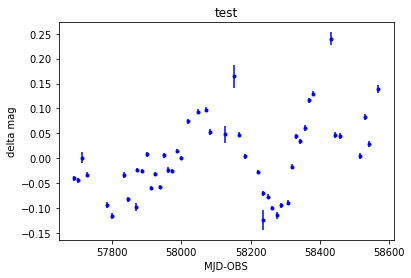

In [2]:
# Read photometry catalogue created by my other script
photfilename = 'F51_out_REMIR_ROS2.fits'
data = fits.getdata(photfilename, 1)

# The photometry catalogue contains aperture photometry in 25 different
# apertures. If we number them 0..24, they correspond to diameters 1..25 arcsec
apno = 10 # This is then 11 arcsec

# The photometry catalogue contains photometry for the AGN plus some more
# objects in the field, in this case the AGN + 6 more objetcs, so 7 in
# total. The AGN is number 1, and the others 2, 3, etc.
# This is seen in the column names, which end in _1, _2, etc.
# E.g. the column MAG_APER_1 contains the aperture magnitudes (for all
# 25 apertures) for the AGN.

# Get the aperture magnitudes
##foo = data['MAG_APER_1'] # has shape e.g. (767, 25), the 25 being the apertures
mag_agn  = data['MAG_APER_1'][:,apno]
mag_ref1 = data['MAG_APER_3'][:,apno] # I have found that _3 is good here
mag_ref2 = data['MAG_APER_4'][:,apno]

# Get the differential magnitudes
delta_mag_agn_ref1 = mag_agn - mag_ref1
delta_mag_ref2_ref1 = mag_ref2 - mag_ref1

# Get the magnitude errors 
magerr_agn = data['MAGERR_APER_1'][:,apno]
magerr_ref1 = data['MAGERR_APER_3'][:,apno]
magerr_ref2= data['MAGERR_APER_4'][:,apno]

# TODO Here I could loop over the filters, subtracting the median

# For simplicity "extract" some arrays from the data
filt = data['filter']
mjd_obs = data['mjd_obs']

# A simple plot of the J band differential mags, with the median subtracted
# Do 'H' and 'K' in the same way
maskJ = (filt == 'J')
#print(magerr_ref1[mask])
#plt.scatter(mjd_obs[mask], delta_mag_agn_ref1[mask]-np.median(delta_mag_agn_ref1[mask]))
plt.errorbar(mjd_obs[maskJ], delta_mag_agn_ref1[maskJ]-np.median(delta_mag_agn_ref1[maskJ]), magerr_ref1[maskJ],fmt='b.')
plt.title('test')
plt.xlabel('MJD-OBS')
plt.ylabel('delta mag')
plt.show()

In [6]:
#J band data
xJ=np.asarray(mjd_obs[maskJ], dtype=float)
nJ=len(xJ)
XJ = np.reshape(xJ,(nJ,1))
yJ=np.asarray(delta_mag_agn_ref1[maskJ]-np.median(delta_mag_agn_ref1[maskJ]), dtype=float)
yJerr = np.array(magerr_ref1[maskJ], dtype=float)

#H band data
maskH = (filt == 'H')
xHtemp=np.asarray(mjd_obs[maskH], dtype=float)
xH=np.delete(xHtemp,(1,2))
nH=len(xH)
XH = np.reshape(xH,(nH,1))
XH_new=np.linspace(min(XH),max(XH),100,dtype=np.float64)
Hdelta_mag_agn_ref1=np.delete(delta_mag_agn_ref1[maskH],(1,2))
yH=np.asarray(Hdelta_mag_agn_ref1-np.median(Hdelta_mag_agn_ref1), dtype=float)
yHerrtemp = np.asarray(magerr_ref1[maskH], dtype=float)
yHerr=np.delete(yHerrtemp,(1,2))

#K band data
maskK = (filt == 'K')
xK=np.asarray(mjd_obs[maskK], dtype=float)
nK=len(xK)
XK = np.reshape(xK,(nK,1))
yK=np.asarray(delta_mag_agn_ref1[maskK]-np.median(delta_mag_agn_ref1[maskK]), dtype=float)
yKerr = np.asarray(magerr_ref1[maskK], dtype=float)

#g band data
maskg = (filt == 'g')
gtemp=delta_mag_agn_ref1[maskg]
gisnan=~np.isnan(gtemp)
xg=np.asarray(mjd_obs[maskg][gisnan], dtype=float)
ng=len(xg)
Xg = np.reshape(xg,(ng,1))
yg=np.asarray(delta_mag_agn_ref1[maskg][gisnan]-np.median(delta_mag_agn_ref1[maskg][gisnan]), dtype=float)
ygerr = np.asarray(magerr_ref1[maskg][gisnan], dtype=float)
#remove values 
xg=xg[(yg>-0.4) & (yg<0.4)]
ng=len(xg)
Xg = np.reshape(xg,(ng,1))
ygerr=ygerr[(yg>-0.4) & (yg<0.4)]
yg=yg[(yg>-0.4) & (yg<0.4)]

#r band data
maskr = (filt == 'r')
rtemp=delta_mag_agn_ref1[maskr]
risnan=~np.isnan(rtemp)
xr=np.asarray(mjd_obs[maskr][risnan], dtype=float)
nr=len(xr)
Xr = np.reshape(xr,(nr,1))
yr=np.asarray(delta_mag_agn_ref1[maskr][risnan]-np.median(delta_mag_agn_ref1[maskr][risnan]), dtype=float)
yrerr = np.asarray(magerr_ref1[maskr][risnan], dtype=float)
#remove values 
xr=xr[(yr>-0.4) & (yr<0.4)]
nr=len(xr)
Xr = np.reshape(xr,(nr,1))
yrerr=yrerr[(yr>-0.4) & (yr<0.4)]
yr=yr[(yr>-0.4) & (yr<0.4)]

#i band data
maski = (filt == 'i')
itemp=delta_mag_agn_ref1[maski]
iisnan=~np.isnan(itemp)
xi=np.asarray(mjd_obs[maski][iisnan], dtype=float)
ni=len(xi)
Xi = np.reshape(xi,(ni,1))
yi=np.asarray(delta_mag_agn_ref1[maski][iisnan]-np.median(delta_mag_agn_ref1[maski][iisnan]), dtype=float)
yierr = np.asarray(magerr_ref1[maski][iisnan], dtype=float)
#remove values 
xi=xi[(yi>-0.4) & (yi<0.4)]
ni=len(xi)
Xi= np.reshape(xi,(ni,1))
yierr=yierr[(yi>-0.4) & (yi<0.4)]
yi=yi[(yi>-0.4) & (yi<0.4)]

#z band data
maskz = (filt == 'z')
ztemp=delta_mag_agn_ref1[maskz]
zisnan=~np.isnan(ztemp)
xz=np.asarray(mjd_obs[maskz][zisnan], dtype=float)
nz=len(xz)
Xz = np.reshape(xz,(nz,1))
yz=np.asarray(delta_mag_agn_ref1[maskz][zisnan]-np.median(delta_mag_agn_ref1[maskz][zisnan]), dtype=float)
yzerr = np.asarray(magerr_ref1[maskz][zisnan], dtype=float)
#remove values 
xz=xz[(yz>-0.4) & (yz<0.4)]
nz=len(xz)
Xz = np.reshape(xz,(nz,1))
yzerr=yzerr[(yz>-0.4) & (yz<0.4)]
yz=yz[(yz>-0.4) & (yz<0.4)]

#time array with all bands
#be carefull with how XJ and xj acts 
X_tot= np.concatenate((xJ,xH,xK,xg,xr,xi,xz),axis=None)
X_tot=np.reshape(X_tot,(len(X_tot),1))

#combine all y values for guess
Y_tot= np.concatenate((yJ,yH,yK,yg,yr,yi,yz),axis=None)
np.std(Y_tot)

0.10103607902340317

In [14]:
print(np.mean(yg),np.mean(yr),np.mean(yi),np.mean(yz),np.mean(yJ),np.mean(yH),np.mean(yK))
print(np.std(yg),np.std(yr),np.std(yi),np.std(yz),np.std(yJ),np.std(yH),np.std(yK))

0.007809715709467044 0.0038937304882293053 0.0035491599176163064 0.011337911381441005 0.0015780001270527743 0.012051249659338664 0.01194034152560764
0.12654150353648286 0.0949564213479466 0.09990248454158213 0.10574327970043529 0.07904578869751422 0.07693179898032056 0.08616310133902279


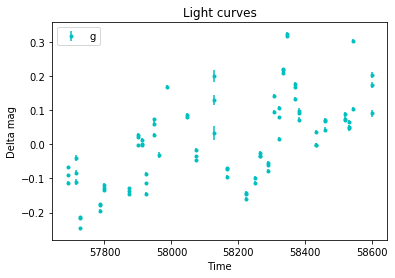

In [20]:
#plt.errorbar(xJ, yJ, yJerr,fmt='b.',label='J')
#plt.errorbar(xH, yH, yHerr,fmt='r.',label='H')
#plt.errorbar(xK, yK, yKerr,fmt='g.',label='K')
plt.errorbar(xg, yg, ygerr,fmt='c.',label='g')
#plt.errorbar(xr, yr, yrerr,fmt='m.',label='r')
#plt.errorbar(xi, yi, yierr,fmt='y.',label='i')
#plt.errorbar(xz, yz, yzerr,fmt='k.',label='z')
plt.title('Light curves')
plt.xlabel('Time')
plt.ylabel('Delta mag')
plt.legend()

# Interpolation function needed for model

In [23]:
#Interpolation function used in model to obtain comparison points with data 
def interpolate(x0, y0, x):
    x = np.array(x)

    idx = np.searchsorted(x0, x)
    dl = np.array(x - x0[idx - 1])
    dr = np.array(x0[idx] - x)
    d = dl + dr
    wl = dr / d

    return wl * y0[idx - 1] + (1 - wl) * y0[idx]

# Simulated data

In [3]:
XJ,yJ,yJerr = np.loadtxt('redJband.txt', delimiter=',', usecols=(0,1,2), unpack=True)
XH,yH,yHerr = np.loadtxt('redHband.txt', delimiter=',', usecols=(0,1,2), unpack=True)
XK,yK,yKerr = np.loadtxt('redKband.txt', delimiter=',', usecols=(0,1,2), unpack=True)
Xg,yg,ygerr = np.loadtxt('redgband.txt', delimiter=',', usecols=(0,1,2), unpack=True)
Xr,yr,yrerr = np.loadtxt('redrband.txt', delimiter=',', usecols=(0,1,2), unpack=True)
Xi,yi,yierr = np.loadtxt('rediband.txt', delimiter=',', usecols=(0,1,2), unpack=True)
Xz,yz,yzerr = np.loadtxt('redzband.txt', delimiter=',', usecols=(0,1,2), unpack=True)
X_tot=[XJ,XH,XK,Xg,Xr,Xi,Xz]
plt.errorbar(XJ, yJ, yJerr, fmt='b.', label='J')
plt.errorbar(XH, yH, yHerr, fmt='r.', label='H')
plt.errorbar(XK, yK, yKerr, fmt='g.', label='K')
plt.errorbar(Xg, yg, ygerr, fmt='c.', label='g')
plt.errorbar(Xr, yr, yrerr, fmt='m.', label='r')
plt.errorbar(Xi, yi, yierr, fmt='y.', label='i')
plt.errorbar(Xz, yz, yzerr, fmt='k.', label='z')
plt.title('Light curves')
plt.xlabel('Time')
plt.ylabel('Delta mag')
plt.legend()

IndexError: list index out of range

In [24]:
#array for GP
nGP=999#len(X_tot)
XGP=np.linspace(np.min(X_tot),np.max(X_tot),nGP)
XGP=np.reshape(XGP,(len(XGP),1))
#time delay array
ntau=999#len(X_tot)
tau=np.linspace(0.0,100.0,ntau)

In [25]:

#THEANO_FLAGS=mode=FAST_RUN,device=cpu,floatX=float32,amdlibm=True
#THEANO_FLAGS='floatX=float32,device=gpu0,lib.amdlibm=True'
#theano.config.lib.amdlibm=True
#theano.config.mode=FAST_RUN
#theano.compile.mode.Mode(linker='py', optimizer='fast_compile')
theano.compile.mode.Mode(linker='cvm', optimizer='fast_run')
#theano.config.floatX='float64'
#theano.compile.debugmode.DebugMode()

In [ ]:
with pm.Model() as convmodel:
    ############################################
    #define driving function as Gaussian Process
    ############################################
    #find way to use g band as first guess of value 
    ℓ = pm.TruncatedNormal('ℓ', mu=0.5, sigma=0.5, lower=0.0)#timescale of variation for the driving function, order of days for UV
    #REMEMBER time scale is 2*ℓ^2 so remember to rewrite as ℓ_true=2*ℓ^2
    η = pm.TruncatedNormal('η', mu=0.5, sigma=0.5, lower=0.0)#long term standard deviation for the driving function
    cov = η**2 * pm.gp.cov.Exponential(1, ls=ℓ)#using same cov as light curve interpolation
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=XGP)
    f = f.reshape((1,1,len(XGP),1))
    ##############
    #Define priors
    ##############
    mmu=3.91202300543#50
    msig=3.91202300543
    mlow=2.3#10
    sigmu=2.0
    sigsig=1.0
    siglow=1.0
    #Universal Dusty Torus parameters for the uniform temperature DT
    sigma_DT=pm.TruncatedNormal('sigma_DT', mu=sigmu,sigma=sigsig,lower=siglow)#needs a source for scale
    m_DT=pm.TruncatedNormal('m_DT', mu=mmu,sigma=msig,lower=mlow)#we expect serveral tens to hundreds of days from the nature letter
    theta_DT=pm.TruncatedNormal('theta_DT', mu=2.25,sigma=2.25,lower=0.0,upper=4.5)#add later when simple model is staple
    #Accretion Disk paramters
    #J band
    Jsigma_AD=pm.TruncatedNormal('Jsigma_AD', mu=sigmu,sigma=sigsig,lower=siglow)# Shappee 2014 suggests somewhere between 0-20 days so log that 
    Jtheta_AD=pm.Normal('Jtheta_AD',mu=0.0,sigma=10.0)#add later 
    Jm_AD=pm.TruncatedNormal('Jm_AD', mu=mmu ,sigma=msig,lower=mlow)#AD has 3-5 times smaller lags than DT 
    #H band
    Hsigma_AD=pm.TruncatedNormal('Hsigma_AD', mu=sigmu,sigma=sigsig,lower=siglow)# Shappee 2014 suggests somewhere between 0-20 days so log that 
    Htheta_AD=pm.Normal('Htheta_AD',mu=0.0,sigma=10.0)#add later 
    Hm_AD=pm.TruncatedNormal('Hm_AD', mu=mmu ,sigma=msig ,lower=mlow)#AD has 3-5 times smaller lags than DT 
    #K band
    Ksigma_AD=pm.TruncatedNormal('Ksigma_AD', mu=sigmu,sigma=sigsig,lower=siglow)# Shappee 2014 suggests somewhere between 0-20 days so log that 
    Ktheta_AD=pm.Normal('Ktheta_AD',mu=0.0,sigma=10.0)#add later 
    Km_AD=pm.TruncatedNormal('Km_AD', mu=mmu ,sigma=msig,lower=mlow)#AD has 3-5 times smaller lags than DT  
    #g band
    gsigma_AD=pm.TruncatedNormal('gsigma_AD', mu=sigmu,sigma=sigsig,lower=siglow)# Shappee 2014 suggests somewhere between 0-20 days so log that 
    gtheta_AD=pm.Normal('gtheta_AD',mu=0.0,sigma=10.0)#add later 
    gm_AD=pm.TruncatedNormal('gm_AD', mu=mmu ,sigma=msig ,lower=mlow)#AD has 3-5 times smaller lags than DT  
    #r band
    rsigma_AD=pm.TruncatedNormal('rsigma_AD', mu=sigmu,sigma=sigsig,lower=siglow)# Shappee 2014 suggests somewhere between 0-20 days so log that 
    rtheta_AD=pm.Normal('rtheta_AD',mu=0.0,sigma=10.0)#add later 
    rm_AD=pm.TruncatedNormal('rm_AD', mu=mmu ,sigma=msig ,lower=mlow)#AD has 3-5 times smaller lags than DT  
    #i band
    isigma_AD=pm.TruncatedNormal('isigma_AD', mu=sigmu,sigma=sigsig,lower=siglow)# Shappee 2014 suggests somewhere between 0-20 days so log that 
    itheta_AD=pm.Normal('itheta_AD',mu=0.0,sigma=10.0)#add later 
    im_AD=pm.TruncatedNormal('im_AD', mu=mmu ,sigma=msig ,lower=mlow)#AD has 3-5 times smaller lags than DT
    #z band
    zsigma_AD=pm.TruncatedNormal('zsigma_AD', mu=sigmu,sigma=sigsig,lower=siglow,testval=sigmu)# Shappee 2014 suggests somewhere between 0-20 days so log that 
    ztheta_AD=pm.Normal('ztheta_AD',mu=0.0,sigma=10.0)#add later 
    zm_AD=pm.TruncatedNormal('zm_AD', mu=mmu ,sigma=msig ,lower=mlow)#AD has 3-5 times smaller lags than DT
    #BB and power law parameters
    T=pm.TruncatedNormal('T', mu=7.2442275156,sigma=0.072,lower=6.90775527898,upper=7.74066440192)#taken from nature letter
    K_0=pm.TruncatedNormal('K_0', mu=1.0,sigma=1.0,lower=0.0)#powr/BB
    index=pm.TruncatedNormal('index', mu=1.5, sigma=0.5,lower=0.0)#sign depends on diffmag definition change to -2 to -1
    #Note for index: we have taken the transformation from F_nu to F_lamb into account with the index value.
                         
    #Different wavelength for different bands, not a free paramter 
    #REMIR filters in nm
    Jwav = 1250.0
    Hwav = 1625.0
    Kwav = 2150.0
    #Sloan filters for ROSS2 in nm
    gwav = 475.4
    rwav = 620.4
    iwav = 769.8
    zwav = 966.5

    #Define constants 
    wav_0 = 1122.4#Reference wavelength in nm, use 500?
    h = 6.626e-34#Plancks constant in J*s
    c = 299792458.0#speed of light in m/s
    k = 1.38e-23#Boltzmanns constant in J/K
    
    #Peak Black Body from uniform torus temperature
    wav_peak = 2.898*10**6/tt.exp(T)
    b_max = 4.967#h*c/(1e-9*wav_peak*k*tt.exp(T))
    BB_max = 1.0/( (wav_peak**5) * (tt.exp(b_max) - 1.0) )
    
    #Universal lognormal for Dusty Torus 
    exp_DT = -((tt.log((tau-tt.exp(theta_DT))/tt.exp(m_DT)))**2/(2*sigma_DT**2)) 
    front_DT = 1.0/((tau-tt.exp(theta_DT))*sigma_DT*tt.sqrt(2*np.pi))
    lognorm_DT = front_DT*tt.exp(exp_DT)
    lognorm_DT = tt.switch(tt.isnan(lognorm_DT), 0.0, lognorm_DT)
    
    #Dusty Torus transfer equation for J band
    Jb = h*c/(1e-9*Jwav*k*tt.exp(T))
    JBB = (1.0/( Jwav**5 * (tt.exp(Jb) - 1.0) ))/BB_max
    JPsi_DT = JBB*lognorm_DT
    #Dusty Torus transfer equation for H band
    Hb = h*c/(1e-9*Hwav*k*tt.exp(T))
    HBB = (1.0/( Hwav**5 * (tt.exp(Hb) - 1.0) ))/BB_max
    HPsi_DT = HBB*lognorm_DT
    #Dusty Torus transfer equation for K band
    Kb = h*c/(1e-9*Kwav*k*tt.exp(T))
    KBB = (1.0/( Kwav**5 * (tt.exp(Kb) - 1.0) ))/BB_max
    KPsi_DT = KBB*lognorm_DT
    #Dusty Torus transfer equation for g band
    gb = h*c/(1e-9*gwav*k*tt.exp(T))
    gBB = (1.0/( gwav**5 * (tt.exp(gb) - 1.0) ))/BB_max
    gPsi_DT = gBB*lognorm_DT   
    #Dusty Torus transfer equation for r band
    rb = h*c/(1e-9*rwav*k*tt.exp(T))
    rBB = (1.0/( rwav**5 * (tt.exp(rb) - 1.0) ))/BB_max
    rPsi_DT = rBB*lognorm_DT
    #Dusty Torus transfer equation for i band
    ib = h*c/(1e-9*iwav*k*tt.exp(T))
    iBB = (1.0/( iwav**5 * (tt.exp(ib) - 1.0) ))/BB_max
    iPsi_DT = iBB*lognorm_DT
    #Dusty Torus transfer equation for z band
    zb = h*c/(1e-9*zwav*k*tt.exp(T))
    zBB = (1.0/( zwav**5 * (tt.exp(zb) - 1.0) ))/BB_max
    zPsi_DT = zBB*lognorm_DT
    
    #Accretion Disk transfer equation for the J band
    Jpowr = K_0*(Jwav/wav_0)**(index)    
    Jexp_AD = -((tt.log((tau-Jtheta_AD)/tt.exp(Jm_AD)))**2/(2*Jsigma_AD**2))
    Jfront_AD = 1.0/((tau-Jtheta_AD)*Jsigma_AD*tt.sqrt(2*np.pi))
    Jlognorm_AD = Jfront_AD*tt.exp(Jexp_AD)
    Jlognorm_AD = tt.switch(tt.isnan(Jlognorm_AD), 0.0, Jlognorm_AD)
    JPsi_AD = Jpowr*Jlognorm_AD
    #Accretion Disk transfer equation for the H band
    Hpowr = K_0*(Hwav/wav_0)**(index)    
    Hexp_AD = -((tt.log((tau-Htheta_AD)/tt.exp(Hm_AD)))**2/(2*Hsigma_AD**2))
    Hfront_AD = 1.0/((tau-Htheta_AD)*Hsigma_AD*tt.sqrt(2*np.pi))
    Hlognorm_AD = Hfront_AD*tt.exp(Hexp_AD)
    Hlognorm_AD = tt.switch(tt.isnan(Hlognorm_AD), 0.0, Hlognorm_AD)
    HPsi_AD = Hpowr*Hlognorm_AD
    #Accretion Disk transfer equation for the K band
    Kpowr = K_0*(Kwav/wav_0)**(index)    
    Kexp_AD = -((tt.log((tau-Ktheta_AD)/tt.exp(Km_AD)))**2/(2*Ksigma_AD**2))
    Kfront_AD = 1.0/((tau-Ktheta_AD)*Ksigma_AD*tt.sqrt(2*np.pi))
    Klognorm_AD = Kfront_AD*tt.exp(Kexp_AD)
    Klognorm_AD = tt.switch(tt.isnan(Klognorm_AD), 0.0, Klognorm_AD)
    KPsi_AD = Kpowr*Klognorm_AD
    #Accretion Disk transfer equation for the g band
    gpowr = K_0*(gwav/wav_0)**(index)    
    gexp_AD = -((tt.log((tau-gtheta_AD)/tt.exp(gm_AD)))**2/(2*gsigma_AD**2))
    gfront_AD = 1.0/((tau-gtheta_AD)*gsigma_AD*tt.sqrt(2*np.pi))
    glognorm_AD = gfront_AD*tt.exp(gexp_AD)
    glognorm_AD = tt.switch(tt.isnan(glognorm_AD), 0.0, glognorm_AD)
    gPsi_AD = gpowr*glognorm_AD
    #Accretion Disk transfer equation for the r band
    rpowr = K_0*(rwav/wav_0)**(index)    
    rexp_AD = -((tt.log((tau-rtheta_AD)/tt.exp(rm_AD)))**2/(2*rsigma_AD**2))
    rfront_AD = 1.0/((tau-rtheta_AD)*rsigma_AD*tt.sqrt(2*np.pi))
    rlognorm_AD = rfront_AD*tt.exp(rexp_AD)
    rlognorm_AD = tt.switch(tt.isnan(rlognorm_AD), 0.0, rlognorm_AD)
    rPsi_AD = rpowr*rlognorm_AD
    #Accretion Disk transfer equation for the i band
    ipowr = K_0*(iwav/wav_0)**(index)    
    iexp_AD = -((tt.log((tau-itheta_AD)/tt.exp(im_AD)))**2/(2*isigma_AD**2))
    ifront_AD = 1.0/((tau-itheta_AD)*isigma_AD*tt.sqrt(2*np.pi))
    ilognorm_AD = ifront_AD*tt.exp(iexp_AD)
    ilognorm_AD = tt.switch(tt.isnan(ilognorm_AD), 0.0, ilognorm_AD)
    iPsi_AD = ipowr*ilognorm_AD
    #Accretion Disk transfer equation for the z band
    zpowr = K_0*(zwav/wav_0)**(index)    
    zexp_AD = -((tt.log((tau-ztheta_AD)/tt.exp(zm_AD)))**2/(2*zsigma_AD**2))
    zfront_AD = 1.0/((tau-ztheta_AD)*zsigma_AD*tt.sqrt(2*np.pi))
    zlognorm_AD = zfront_AD*tt.exp(zexp_AD)
    zlognorm_AD = tt.switch(tt.isnan(zlognorm_AD), 0.0, zlognorm_AD)
    zPsi_AD = zpowr*zlognorm_AD
    
    #########################
    #Full transfer equations
    #########################
    Jtransfer = JPsi_DT + JPsi_AD
    Jtransfer = Jtransfer.reshape(((1,1,len(tau),1)))
    Htransfer = HPsi_DT + HPsi_AD
    Htransfer = Htransfer.reshape(((1,1,len(tau),1)))
    Ktransfer = KPsi_DT + KPsi_AD
    Ktransfer = Ktransfer.reshape(((1,1,len(tau),1)))
    gtransfer = gPsi_DT + gPsi_AD
    gtransfer = gtransfer.reshape(((1,1,len(tau),1)))
    rtransfer = rPsi_DT + rPsi_AD
    rtransfer = rtransfer.reshape(((1,1,len(tau),1)))
    itransfer = iPsi_DT + iPsi_AD
    itransfer = itransfer.reshape(((1,1,len(tau),1)))
    ztransfer = zPsi_DT + zPsi_AD
    ztransfer = ztransfer.reshape(((1,1,len(tau),1)))
    
    #The convolutions
    ######################################################################
    #'half': pad input with a symmetric border of filter rows // 2
    #rows and filter columns // 2 columns, then perform a valid convolution. 
    #For filters with an odd number of rows and columns, 
    #this leads to the output shape being equal to the input shape.
    ######################################################################
    Jconvol=theano.tensor.nnet.conv2d(f,Jtransfer,border_mode='half')
    Jcomp=interpolate(XGP[:,0],Jconvol[0,0,:,0],XJ)
    Hconvol=theano.tensor.nnet.conv2d(f,Htransfer,border_mode='half')
    Hcomp=interpolate(XGP[:,0],Hconvol[0,0,:,0],XH)                     
    Kconvol=theano.tensor.nnet.conv2d(f,Ktransfer,border_mode='half')
    Kcomp=interpolate(XGP[:,0],Kconvol[0,0,:,0],XK)
    gconvol=theano.tensor.nnet.conv2d(f,gtransfer,border_mode='half')
    gcomp=interpolate(XGP[:,0],gconvol[0,0,:,0],Xg)
    rconvol=theano.tensor.nnet.conv2d(f,rtransfer,border_mode='half')
    rcomp=interpolate(XGP[:,0],rconvol[0,0,:,0],Xr)
    iconvol=theano.tensor.nnet.conv2d(f,itransfer,border_mode='half')
    icomp=interpolate(XGP[:,0],iconvol[0,0,:,0],Xi)
    zconvol=theano.tensor.nnet.conv2d(f,ztransfer,border_mode='half')
    zcomp=interpolate(XGP[:,0],zconvol[0,0,:,0],Xz)
    #Define likelihoods
    #kJ = pm.TruncatedNormal('kJ', mu=1.0, sigma=1.0, lower=0.0, upper=3.0)#Noise boost factor
    #kH = pm.TruncatedNormal('kH', mu=1.0, sigma=1.0, lower=0.0, upper=3.0)
    #kK = pm.TruncatedNormal('kK', mu=1.0, sigma=1.0, lower=0.0, upper=3.0)
    #kg = pm.TruncatedNormal('kg', mu=1.0, sigma=1.0, lower=0.0, upper=3.0)
    #kr = pm.TruncatedNormal('kr', mu=1.0, sigma=1.0, lower=0.0, upper=3.0)
    #ki = pm.TruncatedNormal('ki', mu=1.0, sigma=1.0, lower=0.0, upper=3.0)
    #kz = pm.TruncatedNormal('kz', mu=1.0, sigma=1.0, lower=0.0, upper=3.0)
    Jlikelihood = pm.Normal('yJ', mu=Jcomp, sigma=yJerr, observed=yJ)
    Hlikelihood = pm.Normal('yH', mu=Hcomp, sigma=yHerr, observed=yH)
    Klikelihood = pm.Normal('yK', mu=Kcomp, sigma=yKerr, observed=yK)
    glikelihood = pm.Normal('yg', mu=gcomp, sigma=ygerr, observed=yg)
    rlikelihood = pm.Normal('yr', mu=rcomp, sigma=yrerr, observed=yr)
    ilikelihood = pm.Normal('yi', mu=icomp, sigma=yierr, observed=yi)
    zlikelihood = pm.Normal('yz', mu=zcomp, sigma=yzerr, observed=yz)
    #the shape of mu and observed needs to be the same
    ######################################################################
    #max_treedepth, default=10
    #The maximum tree depth. Trajectories are stopped when this depth is reached.
    #early_max_treedepth, default=8
    #The maximum tree depth during the first 200 tuning samples.
    ######################################################################
    
    #tracetransfer = pm.sample(4000,tune=2000,init='advi+adapt_diag',chains=1,cores=8)
    #map_soln = xo.optimize(start=convmodel.test_point)
    #step=xo.get_dense_nuts_step(target_accept=0.8)
    #tracetransfer = pm.sample(draws=5000,tune=5000,chains=1,cores=8,init='auto',step=step)
    #tracetransfer = pm.sample(4000,tune=2000,init='nuts')
    #tracetransfer= pm.fit(300, method='svgd', inf_kwargs=dict(n_particles=1000))
    #tracetransfer= pm.fit(107800,method='advi', callbacks=[CheckParametersConvergence()])
    mp = pm.find_MAP()
    

    #func = convmodel.logp_dlogp_function(profile=True)
    #func.set_extra_values({})
    #x = np.random.randn(func.size)
    #%timeit func(x)

    #func.profile.summary()

/home/malte/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/malte/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
logp = -1.3564e+07, ||grad|| = 1.2565e+05:   1%|▏         | 63/5000 [01:02<4:58:51,  3.63s/it]

In [28]:
pm.summary(mp,names)

/home/malte/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Arra

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
index,0.161,NaN,0.161,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
K_0,2.093,NaN,2.093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
T,7.278,NaN,7.278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zm_AD,3.213,NaN,3.213,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ztheta_AD,-0.451,NaN,-0.451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
zsigma_AD,2.127,NaN,2.127,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
im_AD,9.360,NaN,9.360,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
itheta_AD,-0.125,NaN,-0.125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
isigma_AD,1.771,NaN,1.771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rm_AD,3.207,NaN,3.207,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#To Do
#do noise boost factor for different bands
#try to implement in stan or pymc4 if pymc3 fails

In [27]:
names=['index', 'K_0', 'T', 
       'zm_AD', 'ztheta_AD', 'zsigma_AD', 
       'im_AD', 'itheta_AD', 'isigma_AD', 
       'rm_AD', 'rtheta_AD', 'rsigma_AD', 
       'gm_AD', 'gtheta_AD', 'gsigma_AD', 
       'Km_AD', 'Ktheta_AD', 'Ksigma_AD', 
       'Hm_AD', 'Htheta_AD', 'Hsigma_AD', 
       'Jm_AD', 'Jtheta_AD', 'Jsigma_AD', 
       'theta_DT', 'm_DT', 'sigma_DT', 'η', 'ℓ']
#stepsize should be similar
plt.plot(tracetransfer['step_size_bar'])

NameError: name 'tracetransfer' is not defined

In [ ]:
pm.plot_posterior(tracetransfer.sample(1000),var_names=names ,color='LightSeaGreen');

In [ ]:
import seaborn as sb
accept = tracetransfer.get_sampler_stats('mean_tree_accept', burn=1000)
sb.distplot(accept, kde=False)

In [ ]:
#energy plot should be similar 
energy = tracetransfer['energy']
energy_diff = np.diff(energy)
sb.distplot(energy - energy.mean(), label='energy')
sb.distplot(energy_diff, label='energy diff')
plt.legend()

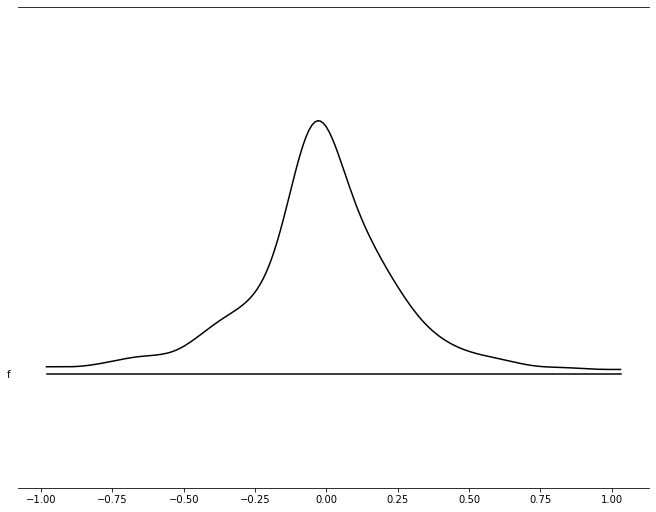

In [30]:
#plot of all the GP variables
pm.plot_forest(tracetransfer,
               kind='ridgeplot',
               var_names=['f'],
               combined=False,
               ridgeplot_overlap=3,
               ridgeplot_alpha=.25,
               colors='white',
               figsize=(9, 7));

In [ ]:
pm.summary(tracetransfer,names)#.round(2)

In [ ]:
pm.traceplot(tracetransfer, var_names=names);

In [ ]:
pm.plot_posterior(tracetransfer,names);

In [ ]:
pm.pairplot(tracetransfer, var_names=names, divergences=True);

AxisError: axis 1 is out of bounds for array of dimension 1

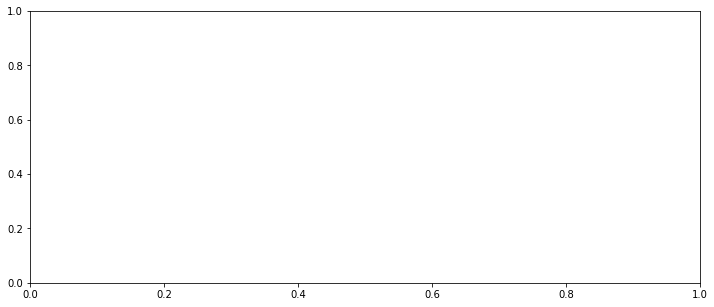

In [29]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
#plot_gp_dist(ax, tracetransfer["f"], XGP);
plot_gp_dist(ax, mp["f"], XGP);
# plot the data and the true latent function
#plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("time"); plt.ylabel("delta mag");
plt.title("Driving function");

In [ ]:
n_new = 1001
X_new = np.linspace(min(X_tot), max(X_tot), n_new)

# add the GP conditional to the model, given the new X values
with convmodel:
    f_tot = gp.conditional("f_tot", X_new)

# Sample from the GP conditional distribution
with convmodel:
    pred_samples = pm.sample_posterior_predictive(tracetransfer, vars=[f_tot], samples=10000)

In [ ]:
# plot the results

fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, pred_samples["f_new"], X_new);
#plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");
plt.xlabel("X"); plt.ylabel("f(X)");
plt.title("Conditional distribution of f_*, given f");

In [ ]:
#Calculate the mean and standard deviation of the traces. 
mu = np.zeros(len(X_new))
sd = np.zeros(len(X_new))

for i in range(0,len(X_new)):
    mu[i] = np.mean(pred_samples["f_tot"][:,i])
    sd[i] = np.std(pred_samples["f_tot"][:,i])

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 1σ intervals
#plt.plot(X_new, mu, 'r', lw=2, label="mean and 1σ region");
#plt.plot(X_new, mu + 1*sd, 'r', lw=1); plt.plot(X_new, mu - 1*sd, 'r', lw=1);
#plt.fill_between(X_new.flatten(), mu - 1*sd, mu + 1*sd, color="r", alpha=0.5)
plt.errorbar(X_tot,mu,sd,fmt='r.',label='Driving function value at data points')

# plot original data and true function
#plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data")
#plt.errorbar(X, y, yerr,fmt='.',label="observed data")

plt.xlabel("t");
plt.ylabel("diffmag")
plt.title("predictive mean and 1σ interval"); plt.legend();
print(np.mean(sd))

In [ ]:
plt.errorbar(xJ, yJ, yJerr,fmt='b.',label='J')
plt.errorbar(xH, yH, yHerr,fmt='g.',label='H')
plt.errorbar(xK, yK, yKerr,fmt='r.',label='K')
plt.errorbar(X_tot,mu,sd,fmt='k.',label='Driving')
plt.legend()

# Check transfer functions

In [ ]:
def transfertest(theta,tau):
    (sigma_DT, m_DT, theta_DT, 
     Jsigma_AD, Jm_AD, Jtheta_AD,
     Hsigma_AD, Hm_AD, Htheta_AD,
     Ksigma_AD, Km_AD, Ktheta_AD,
     gsigma_AD, gm_AD, gtheta_AD,
     rsigma_AD, rm_AD, rtheta_AD,
     isigma_AD, im_AD, itheta_AD,
     zsigma_AD, zm_AD, ztheta_AD,
     T, K_0, index)= theta
    #Different wavelength for different bands, not a free paramter 
    #REMIR filters in nm
    Jwav = 1250.0
    Hwav = 1625.0
    Kwav = 2150.0
    #Sloan filters for ROSS2 in nm
    gwav = 475.4
    rwav = 620.4
    iwav = 769.8
    zwav = 966.5

    #Define constants 
    wav_0 = 1122.4#Reference wavelength in nm, use 500?
    h = 6.626e-34#Plancks constant in J*s
    c = 299792458.0#speed of light in m/s
    k = 1.38e-23#Boltzmanns constant in J/K
    T = np.exp(T)
    theta_DT = np.exp(theta_DT)
    #Peak Black Body from uniform torus temperature
    wav_peak = 2.898*10**6/T
    b_max = 4.967#h*c/(1e-9*wav_peak*k*T)
    BB_max = 1.0/( (wav_peak**5) * (np.exp(b_max) - 1.0) )
    
    #Universal lognormal for Dusty Torus 
    exp_DT = -((np.log((tau-theta_DT)/np.exp(m_DT)))**2/(2*sigma_DT**2)) 
    front_DT = 1.0/((tau-theta_DT)*sigma_DT*np.sqrt(2*np.pi))
    lognorm_DT = front_DT*np.exp(exp_DT)
    where_are_NaNsDT = np.isnan(lognorm_DT)
    lognorm_DT[where_are_NaNsDT] = 0.0
    
    #Dusty Torus transfer equation for J band
    Jb = h*c/(1e-9*Jwav*k*T)
    JBB = (1.0/( Jwav**5 * (np.exp(Jb) - 1.0) ))/BB_max
    JPsi_DT = JBB*lognorm_DT
    #Dusty Torus transfer equation for H band
    Hb = h*c/(1e-9*Hwav*k*T)
    HBB = (1.0/( Hwav**5 * (np.exp(Hb) - 1.0) ))/BB_max
    HPsi_DT = HBB*lognorm_DT
    #Dusty Torus transfer equation for K band
    Kb = h*c/(1e-9*Kwav*k*T)
    KBB = (1.0/( Kwav**5 * (np.exp(Kb) - 1.0) ))/BB_max
    KPsi_DT = KBB*lognorm_DT
    #Dusty Torus transfer equation for g band
    gb = h*c/(1e-9*gwav*k*T)
    gBB = (1.0/( gwav**5 * (np.exp(gb) - 1.0) ))/BB_max
    gPsi_DT = gBB*lognorm_DT   
    #Dusty Torus transfer equation for r band
    rb = h*c/(1e-9*rwav*k*T)
    rBB = (1.0/( rwav**5 * (np.exp(rb) - 1.0) ))/BB_max
    rPsi_DT = rBB*lognorm_DT
    #Dusty Torus transfer equation for i band
    ib = h*c/(1e-9*iwav*k*T)
    iBB = (1.0/( iwav**5 * (np.exp(ib) - 1.0) ))/BB_max
    iPsi_DT = iBB*lognorm_DT
    #Dusty Torus transfer equation for z band
    zb = h*c/(1e-9*zwav*k*T)
    zBB = (1.0/( zwav**5 * (np.exp(zb) - 1.0) ))/BB_max
    zPsi_DT = zBB*lognorm_DT
    
    #Accretion Disk transfer equation for the J band
    Jpowr = K_0*(Jwav/wav_0)**(index)    
    Jexp_AD = -((np.log((tau-Jtheta_AD)/np.exp(Jm_AD)))**2/(2*Jsigma_AD**2))
    Jfront_AD = 1.0/((tau-Jtheta_AD)*Jsigma_AD*np.sqrt(2*np.pi))
    Jlognorm_AD = Jfront_AD*np.exp(Jexp_AD)
    Jwhere_are_NaNs = np.isnan(Jlognorm_AD)
    Jlognorm_AD[Jwhere_are_NaNs] = 0.0
    JPsi_AD = Jpowr*Jlognorm_AD
    #Accretion Disk transfer equation for the H band
    Hpowr = K_0*(Hwav/wav_0)**(index)    
    Hexp_AD = -((np.log((tau-Htheta_AD)/np.exp(Hm_AD)))**2/(2*Hsigma_AD**2))
    Hfront_AD = 1.0/((tau-Htheta_AD)*Hsigma_AD*np.sqrt(2*np.pi))
    Hlognorm_AD = Hfront_AD*np.exp(Hexp_AD)
    Hwhere_are_NaNs = np.isnan(Hlognorm_AD)
    Hlognorm_AD[Hwhere_are_NaNs] = 0.0
    HPsi_AD = Hpowr*Hlognorm_AD
    #Accretion Disk transfer equation for the K band
    Kpowr = K_0*(Kwav/wav_0)**(index)    
    Kexp_AD = -((np.log((tau-Ktheta_AD)/np.exp(Km_AD)))**2/(2*Ksigma_AD**2))
    Kfront_AD = 1.0/((tau-Ktheta_AD)*Ksigma_AD*np.sqrt(2*np.pi))
    Klognorm_AD = Kfront_AD*np.exp(Kexp_AD)
    Kwhere_are_NaNs = np.isnan(Klognorm_AD)
    Klognorm_AD[Kwhere_are_NaNs] = 0.0
    KPsi_AD = Kpowr*Klognorm_AD
    #Accretion Disk transfer equation for the g band
    gpowr = K_0*(gwav/wav_0)**(index)    
    gexp_AD = -((np.log((tau-gtheta_AD)/np.exp(gm_AD)))**2/(2*gsigma_AD**2))
    gfront_AD = 1.0/((tau-gtheta_AD)*gsigma_AD*np.sqrt(2*np.pi))
    glognorm_AD = gfront_AD*np.exp(gexp_AD)
    gwhere_are_NaNs = np.isnan(glognorm_AD)
    glognorm_AD[gwhere_are_NaNs] = 0.0
    gPsi_AD = gpowr*glognorm_AD
    #Accretion Disk transfer equation for the r band
    rpowr = K_0*(rwav/wav_0)**(index)    
    rexp_AD = -((np.log((tau-rtheta_AD)/np.exp(rm_AD)))**2/(2*rsigma_AD**2))
    rfront_AD = 1.0/((tau-rtheta_AD)*rsigma_AD*np.sqrt(2*np.pi))
    rlognorm_AD = rfront_AD*np.exp(rexp_AD)
    rwhere_are_NaNs = np.isnan(rlognorm_AD)
    rlognorm_AD[rwhere_are_NaNs] = 0.0
    rPsi_AD = rpowr*rlognorm_AD
    #Accretion Disk transfer equation for the i band
    ipowr = K_0*(iwav/wav_0)**(index)    
    iexp_AD = -((np.log((tau-itheta_AD)/np.exp(im_AD)))**2/(2*isigma_AD**2))
    ifront_AD = 1.0/((tau-itheta_AD)*isigma_AD*np.sqrt(2*np.pi))
    ilognorm_AD = ifront_AD*np.exp(iexp_AD)
    iwhere_are_NaNs = np.isnan(ilognorm_AD)
    ilognorm_AD[iwhere_are_NaNs] = 0.0
    iPsi_AD = ipowr*ilognorm_AD
    #Accretion Disk transfer equation for the z band
    zpowr = K_0*(zwav/wav_0)**(index)    
    zexp_AD = -((np.log((tau-ztheta_AD)/np.exp(zm_AD)))**2/(2*zsigma_AD**2))
    zfront_AD = 1.0/((tau-ztheta_AD)*zsigma_AD*np.sqrt(2*np.pi))
    zlognorm_AD = zfront_AD*np.exp(zexp_AD)
    zwhere_are_NaNs = np.isnan(zlognorm_AD)
    zlognorm_AD[zwhere_are_NaNs] = 0.0
    zPsi_AD = zpowr*zlognorm_AD
    
    #Full transfer equations
    Jtransfer = JPsi_DT + JPsi_AD
    Htransfer = HPsi_DT + HPsi_AD
    Ktransfer = KPsi_DT + KPsi_AD
    gtransfer = gPsi_DT + gPsi_AD
    rtransfer = rPsi_DT + rPsi_AD
    itransfer = iPsi_DT + iPsi_AD
    ztransfer = zPsi_DT + zPsi_AD
    
    #plt.plot(tau,Jtransfer,'b', label='J')
    #plt.plot(tau,Htransfer,'r', label='H')
    #plt.plot(tau,Ktransfer,'g', label='K')
    #plt.plot(tau,gtransfer,'c', label='g')
    #plt.plot(tau,rtransfer,'m', label='r')
    #plt.plot(tau,itransfer,'y', label='i')
    #plt.plot(tau,ztransfer,'k', label='z')
    plt.plot(tau,lognorm_DT,'k',label='DT')
    plt.title('Light curves')
    plt.xlabel('Time')
    plt.ylabel('Delta mag')
    plt.legend()
    
    return [Jtransfer,Htransfer,Ktransfer,gtransfer,rtransfer,itransfer,ztransfer]

In [ ]:
summ=pm.summary(tracetransfer,names)

In [ ]:
theta=np.array(list(reverse(summ.loc[:,'mean'][0:27])))
a = transfertest(theta,tau[0:1000])

In [ ]:
mu,sigma,n = 1.58,1.58,3000

def normal(x,mu,sigma):
    return ( 2.*np.pi*sigma**2. )**-.5 * np.exp( -.5 * (x-mu)**2. / sigma**2. )

x = np.random.normal(mu,sigma,n) 
y = normal(x,mu,sigma) 
y_log=normal(np.log(x),mu,sigma)

plt.plot(x,y,'.')


# Specify simple model to save time 

In [16]:
nf = 86*2
Xf = np.linspace(np.min([XK,Xg]), np.max([XK,Xg]), nf)
Xf=np.reshape(Xf,(len(Xf),1))
tau=np.linspace(0.0,100.0,nf)
print(len(yg))

86


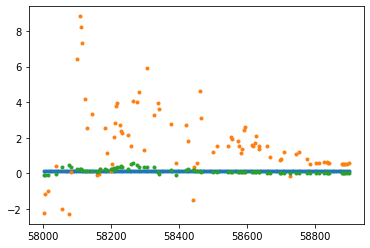

In [17]:
plt.plot(Xf,2e-6*Xf,'.')
plt.plot(XK,yK,'.')
plt.plot(Xg,yg,'.')

In [11]:
mmu=3.91202300543#50
msig=3.91202300543
mlow=2.3#10
sigmu=2.0
sigsig=1.0
siglow=1.0

#Different wavelength for different bands, not a free paramter 
#REMIR filters in nm
Kwav = 2150.0
#Sloan filters for ROSS2 in nm
gwav = 475.4

#Define constants 
wav_0 = 1122.4#Reference wavelength in nm, use 500?
h = 6.626e-34#Plancks constant in J*s
c = 299792458.0#speed of light in m/s
k = 1.38e-23#Boltzmanns constant in J/K

b_max = 4.967

In [ ]:
with pm.Model() as convmodel:
    ############################################
    #define driving function as Gaussian Process
    ############################################
    #find way to use g band as first guess of value 
    ℓ = pm.TruncatedNormal('ℓ', mu=0.70710678118, sigma=0.70710678118, lower=0.0)#timescale of variation for the driving function, order of days for UV
    #REMEMBER time scale is 2*ℓ^2 so remember to rewrite as ℓ_true=2*ℓ^2
    η = pm.TruncatedNormal('η', mu=0.5, sigma=0.5, lower=0.0)#long term standard deviation for the driving function
    cov = η**2 * pm.gp.cov.Exponential(1, ls=ℓ)#using same cov as light curve interpolation
    gp = pm.gp.Latent(cov_func=cov)
    f = gp.prior("f", X=Xf)
    #f = f.reshape((1,1,len(Xf),1))
    
    ##############
    #Define priors
    ##############
    #Universal Dusty Torus parameters for the uniform temperature DT
    sigma_DT=pm.TruncatedNormal('sigma_DT', mu=sigmu,sigma=sigsig,lower=siglow)#needs a source for scale
    m_DT=pm.TruncatedNormal('m_DT', mu=3.91202300543,sigma=3.91202300543,lower=mlow)#we expect serveral tens to hundreds of days from the nature letter
    theta_DT=pm.TruncatedNormal('theta_DT', mu=2.25,sigma=2.25,lower=0.0,upper=4.5)#add later when simple model is staple
    #Accretion Disk paramters
    #K band
    Ksigma_AD=pm.TruncatedNormal('Ksigma_AD', mu=sigmu,sigma=sigsig,lower=siglow)# Shappee 2014 suggests somewhere between 0-20 days so log that 
    Ktheta_AD=pm.Normal('Ktheta_AD',mu=0.0,sigma=10.0)#add later 
    Km_AD=pm.TruncatedNormal('Km_AD', mu=3.91202300543 ,sigma=3.91202300543,lower=mlow)#AD has 3-5 times smaller lags than DT  
    #g band
    gsigma_AD=pm.TruncatedNormal('gsigma_AD', mu=sigmu,sigma=sigsig,lower=siglow)# Shappee 2014 suggests somewhere between 0-20 days so log that 
    gtheta_AD=pm.Normal('gtheta_AD',mu=0.0,sigma=10.0)#add later 
    gm_AD=pm.TruncatedNormal('gm_AD', mu=3.91202300543 ,sigma=3.91202300543 ,lower=mlow)#AD has 3-5 times smaller lags than DT  
    #BB and power law parameters
    T=pm.TruncatedNormal('T', mu=7.2442275156,sigma=0.072,lower=6.90775527898,upper=7.74066440192)#taken from nature letter
    K_0=pm.TruncatedNormal('K_0', mu=1.0,sigma=1.0,lower=0.0)#powr/BB
    index=pm.Normal('index', mu=1.5, sigma=0.5)#sign depends on diffmag definition change to -2 to -1
    #Note for index: we have taken the transformation from F_nu to F_lamb into account with the index value.
                         

    
    #Peak Black Body from uniform torus temperature
    wav_peak = 2.898*10**6/tt.exp(T)
    #b_max = 4.967#h*c/(1e-9*wav_peak*k*tt.exp(T))
    BB_max = 1.0/( (wav_peak**5) * (tt.exp(b_max) - 1.0) )
    
    #Universal lognormal for Dusty Torus 
    exp_DT = -((tt.log((tau-tt.exp(theta_DT))/tt.exp(m_DT)))**2/(2*sigma_DT**2)) 
    front_DT = 1.0/((tau-tt.exp(theta_DT))*sigma_DT*tt.sqrt(2*np.pi))
    lognorm_DT = front_DT*tt.exp(exp_DT)
    lognorm_DT = tt.switch(tt.isnan(lognorm_DT), 0.0, lognorm_DT)
    

    #Dusty Torus transfer equation for K band
    Kb = h*c/(1e-9*Kwav*k*tt.exp(T))
    KBB = (1.0/( Kwav**5 * (tt.exp(Kb) - 1.0) ))/BB_max
    KPsi_DT = KBB*lognorm_DT
    #Dusty Torus transfer equation for g band
    gb = h*c/(1e-9*gwav*k*tt.exp(T))
    gBB = (1.0/( gwav**5 * (tt.exp(gb) - 1.0) ))/BB_max
    gPsi_DT = gBB*lognorm_DT   
    

    #Accretion Disk transfer equation for the K band
    Kpowr = K_0*(Kwav/wav_0)**(index)    
    Kexp_AD = -((tt.log((tau-Ktheta_AD)/tt.exp(Km_AD)))**2/(2*Ksigma_AD**2))
    Kfront_AD = 1.0/((tau-Ktheta_AD)*Ksigma_AD*tt.sqrt(2*np.pi))
    Klognorm_AD = Kfront_AD*tt.exp(Kexp_AD)
    Klognorm_AD = tt.switch(tt.isnan(Klognorm_AD), 0.0, Klognorm_AD)
    KPsi_AD = Kpowr*Klognorm_AD
    #Accretion Disk transfer equation for the g band
    gpowr = K_0*(gwav/wav_0)**(index)    
    gexp_AD = -((tt.log((tau-gtheta_AD)/tt.exp(gm_AD)))**2/(2*gsigma_AD**2))
    gfront_AD = 1.0/((tau-gtheta_AD)*gsigma_AD*tt.sqrt(2*np.pi))
    glognorm_AD = gfront_AD*tt.exp(gexp_AD)
    glognorm_AD = tt.switch(tt.isnan(glognorm_AD), 0.0, glognorm_AD)
    gPsi_AD = gpowr*glognorm_AD
    
    #########################
    #Full transfer equations
    #########################

    Ktransfer = KPsi_DT + KPsi_AD
    #Ktransfer = Ktransfer.reshape(((1,1,len(tau),1)))
    gtransfer = gPsi_DT + gPsi_AD
    #gtransfer = gtransfer.reshape(((1,1,len(tau),1)))
    
    #The convolutions
    ######################################################################
    #'half': pad input with a symmetric border of filter rows // 2
    #rows and filter columns // 2 columns, then perform a valid convolution. 
    #For filters with an odd number of rows and columns, 
    #this leads to the output shape being equal to the input shape.
    ######################################################################
                   
    #Kconvol=theano.tensor.nnet.conv2d(f,Ktransfer,border_mode='half')
    #Kcomp=interpolate(Xf[:,0],Kconvol[0,0,:,0],XK)
    Kconvol=scipy.signal.fftconvolve(f,Ktransfer,mode='same')
    Kcomp=interpolate(Xf[:,0],Kconvol,XK)
    
    #gconvol=theano.tensor.nnet.conv2d(f,gtransfer,border_mode='half')
    #gcomp=interpolate(Xf[:,0],gconvol[0,0,:,0],Xg)
    gconvol=scipy.signal.fftconvolve(f,gtransfer,mode='same')
    gcomp=interpolate(Xf[:,0],gconvol,Xg)

    #Define likelihoods

    #kK = pm.TruncatedNormal('kK', mu=1.0, sigma=1.0, lower=0.0, upper=3.0)
    #kg = pm.TruncatedNormal('kg', mu=1.0, sigma=1.0, lower=0.0, upper=3.0)

    Klikelihood = pm.Normal('yK', mu=Kcomp, sigma=yKerr, observed=yK)
    glikelihood = pm.Normal('yg', mu=gcomp, sigma=ygerr, observed=yg)
    
    #the shape of mu and observed needs to be the same
    ######################################################################
    #max_treedepth, default=10
    #The maximum tree depth. Trajectories are stopped when this depth is reached.
    #early_max_treedepth, default=8
    #The maximum tree depth during the first 200 tuning samples.
    ######################################################################
    
    tracetransfer = pm.sample(4000,tune=2000,init='advi+adapt_diag',chains=2)
    #map_soln = xo.optimize(start=convmodel.test_point)
    #step=xo.get_dense_nuts_step()
    #tracetransfer = pm.sample(draws=5000,tune=5000,chains=1,cores=8,step=step)
    #tracesimple = pm.sample(1000,tune=500,init='advi+adapt_diag',n_init=10000)
    #tracetransfer= pm.fit(300, method='svgd', inf_kwargs=dict(n_particles=1000))
    #tracetransfer= pm.fit(139900,method='advi', callbacks=[CheckParametersConvergence()])
    #mp = pm.find_MAP()

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /home/malte/.theano/compiledir_Linux-5.3--generic-x86_64-with-debian-buster-sid-x86_64-3.7.4-64/lock_dir/lock


  0%|          | 0/200000 [00:00<?, ?it/s]/home/malte/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


Average Loss = 2.5256e+07:   0%|          | 0/200000 [00:00<?, ?it/s]

Average Loss = 2.5256e+07:   0%|          | 0/200000 [00:00<?, ?it/s]

Average Loss = 2.5402e+07:   0%|          | 0/200000 [00:00<?, ?it/s]

Average Loss = 2.5402e+07:   0%|          | 0/200000 [00:00<?, ?it/s]

Average Loss = 2.5323e+07:   0%|          | 0/200000 [00:00

Average Loss = 2.5388e+07:   0%|          | 706/200000 [00:03<15:16, 217.36it/s]

Average Loss = 2.5388e+07:   0%|          | 731/200000 [00:03<14:41, 226.06it/s]

Average Loss = 2.5387e+07:   0%|          | 731/200000 [00:03<14:41, 226.06it/s]

Average Loss = 2.5387e+07:   0%|          | 731/200000 [00:03<14:41, 226.06it/s]

Average Loss = 2.5386e+07:   0%|          | 731/200000 [00:03<14:41, 226.06it/s]

Average Loss = 2.5386e+07:   0%|          | 731/200000 [00:03<14:41, 226.06it/s]

Average Loss = 2.5386e+07:   0%|          | 757/200000 [00:03<14:10, 234.35it/s]

Average Loss = 2.5387e+07:   0%|          | 757/200000 [00:03<14:10, 234.35it/s]

Average Loss = 2.5387e+07:   0%|          | 757/200000 [00:03<14:10, 234.35it/s]

Average Loss = 2.5388e+07:   0%|          | 757/200000 [00:03<14:10, 234.35it/s]

Average Loss = 2.5388e+07:   0%|          | 757/200000 [00:03<14:10, 234.35it/s]

Average Loss = 2.5387e+07:   0%|          | 757/200000 [00:03<14:10, 234.35it/s]

Average Loss = 2

Average Loss = 2.5287e+07:   1%|          | 1476/200000 [00:07<17:33, 188.50it/s]

Average Loss = 2.5287e+07:   1%|          | 1476/200000 [00:07<17:33, 188.50it/s]

Average Loss = 2.5287e+07:   1%|          | 1496/200000 [00:07<18:03, 183.25it/s]

Average Loss = 2.5285e+07:   1%|          | 1496/200000 [00:07<18:03, 183.25it/s]

Average Loss = 2.5285e+07:   1%|          | 1496/200000 [00:07<18:03, 183.25it/s]

Average Loss = 2.5283e+07:   1%|          | 1496/200000 [00:07<18:03, 183.25it/s]

Average Loss = 2.5283e+07:   1%|          | 1496/200000 [00:07<18:03, 183.25it/s]

Average Loss = 2.5283e+07:   1%|          | 1515/200000 [00:07<18:03, 183.15it/s]

Average Loss = 2.5282e+07:   1%|          | 1515/200000 [00:07<18:03, 183.15it/s]

Average Loss = 2.5282e+07:   1%|          | 1515/200000 [00:07<18:03, 183.15it/s]

Average Loss = 2.528e+07:   1%|          | 1515/200000 [00:07<18:03, 183.15it/s] 

Average Loss = 2.528e+07:   1%|          | 1515/200000 [00:07<18:03, 183.15it/s]

Avera

Average Loss = 2.5055e+07:   1%|          | 2240/200000 [00:10<16:01, 205.72it/s]

Average Loss = 2.5042e+07:   1%|          | 2240/200000 [00:10<16:01, 205.72it/s]

Average Loss = 2.5042e+07:   1%|          | 2240/200000 [00:10<16:01, 205.72it/s]

Average Loss = 2.5042e+07:   1%|          | 2262/200000 [00:10<16:29, 199.78it/s]

Average Loss = 2.5043e+07:   1%|          | 2262/200000 [00:10<16:29, 199.78it/s]

Average Loss = 2.5043e+07:   1%|          | 2262/200000 [00:10<16:29, 199.78it/s]

Average Loss = 2.504e+07:   1%|          | 2262/200000 [00:10<16:29, 199.78it/s] 

Average Loss = 2.504e+07:   1%|          | 2262/200000 [00:10<16:29, 199.78it/s]

Average Loss = 2.504e+07:   1%|          | 2283/200000 [00:10<17:10, 191.80it/s]

Average Loss = 2.5037e+07:   1%|          | 2283/200000 [00:10<17:10, 191.80it/s]

Average Loss = 2.5037e+07:   1%|          | 2283/200000 [00:10<17:10, 191.80it/s]

Average Loss = 2.5034e+07:   1%|          | 2283/200000 [00:10<17:10, 191.80it/s]

Averag

Average Loss = 2.4523e+07:   2%|▏         | 3010/200000 [00:14<19:19, 169.82it/s]

Average Loss = 2.4523e+07:   2%|▏         | 3010/200000 [00:14<19:19, 169.82it/s]

Average Loss = 2.4511e+07:   2%|▏         | 3010/200000 [00:14<19:19, 169.82it/s]

Average Loss = 2.4511e+07:   2%|▏         | 3010/200000 [00:14<19:19, 169.82it/s]

Average Loss = 2.4504e+07:   2%|▏         | 3010/200000 [00:14<19:19, 169.82it/s]

Average Loss = 2.4504e+07:   2%|▏         | 3010/200000 [00:14<19:19, 169.82it/s]

Average Loss = 2.4504e+07:   2%|▏         | 3031/200000 [00:14<18:15, 179.87it/s]

Average Loss = 2.4491e+07:   2%|▏         | 3031/200000 [00:14<18:15, 179.87it/s]

Average Loss = 2.4491e+07:   2%|▏         | 3031/200000 [00:14<18:15, 179.87it/s]

Average Loss = 2.4499e+07:   2%|▏         | 3031/200000 [00:14<18:15, 179.87it/s]

Average Loss = 2.4499e+07:   2%|▏         | 3031/200000 [00:14<18:15, 179.87it/s]

Average Loss = 2.4499e+07:   2%|▏         | 3054/200000 [00:14<17:06, 191.80it/s]

Aver

Average Loss = 2.3607e+07:   2%|▏         | 3767/200000 [00:17<16:09, 202.38it/s]

Average Loss = 2.36e+07:   2%|▏         | 3767/200000 [00:17<16:09, 202.38it/s]  

Average Loss = 2.36e+07:   2%|▏         | 3767/200000 [00:17<16:09, 202.38it/s]

Average Loss = 2.3593e+07:   2%|▏         | 3767/200000 [00:17<16:09, 202.38it/s]

Average Loss = 2.3593e+07:   2%|▏         | 3767/200000 [00:17<16:09, 202.38it/s]

Average Loss = 2.3593e+07:   2%|▏         | 3792/200000 [00:17<15:22, 212.76it/s]

Average Loss = 2.3588e+07:   2%|▏         | 3792/200000 [00:17<15:22, 212.76it/s]

Average Loss = 2.3588e+07:   2%|▏         | 3792/200000 [00:17<15:22, 212.76it/s]

Average Loss = 2.3561e+07:   2%|▏         | 3792/200000 [00:17<15:22, 212.76it/s]

Average Loss = 2.3561e+07:   2%|▏         | 3792/200000 [00:17<15:22, 212.76it/s]

Average Loss = 2.3561e+07:   2%|▏         | 3818/200000 [00:17<14:38, 223.25it/s]

Average Loss = 2.3551e+07:   2%|▏         | 3818/200000 [00:17<14:38, 223.25it/s]

Averag

Average Loss = 2.2116e+07:   2%|▏         | 4527/200000 [00:21<14:15, 228.48it/s]

Average Loss = 2.2116e+07:   2%|▏         | 4527/200000 [00:21<14:15, 228.48it/s]

Average Loss = 2.2087e+07:   2%|▏         | 4527/200000 [00:21<14:15, 228.48it/s]

Average Loss = 2.2087e+07:   2%|▏         | 4527/200000 [00:21<14:15, 228.48it/s]

Average Loss = 2.2087e+07:   2%|▏         | 4553/200000 [00:21<13:48, 235.87it/s]

Average Loss = 2.2036e+07:   2%|▏         | 4553/200000 [00:21<13:48, 235.87it/s]

Average Loss = 2.2036e+07:   2%|▏         | 4553/200000 [00:21<13:48, 235.87it/s]

Average Loss = 2.2019e+07:   2%|▏         | 4553/200000 [00:21<13:48, 235.87it/s]

Average Loss = 2.2019e+07:   2%|▏         | 4553/200000 [00:21<13:48, 235.87it/s]

Average Loss = 2.2019e+07:   2%|▏         | 4580/200000 [00:21<13:21, 243.79it/s]

Average Loss = 2.204e+07:   2%|▏         | 4580/200000 [00:21<13:21, 243.79it/s] 

Average Loss = 2.204e+07:   2%|▏         | 4580/200000 [00:21<13:21, 243.79it/s]

Avera

Average Loss = 2.1994e+07:   3%|▎         | 5290/200000 [00:24<14:26, 224.74it/s]

Average Loss = 2.1994e+07:   3%|▎         | 5314/200000 [00:24<14:59, 216.45it/s]

Average Loss = 2.1974e+07:   3%|▎         | 5314/200000 [00:24<14:59, 216.45it/s]

Average Loss = 2.1974e+07:   3%|▎         | 5314/200000 [00:24<14:59, 216.45it/s]

Average Loss = 2.1987e+07:   3%|▎         | 5314/200000 [00:24<14:59, 216.45it/s]

Average Loss = 2.1987e+07:   3%|▎         | 5314/200000 [00:24<14:59, 216.45it/s]

Average Loss = 2.1987e+07:   3%|▎         | 5337/200000 [00:24<17:09, 189.03it/s]

Average Loss = 2.1964e+07:   3%|▎         | 5337/200000 [00:24<17:09, 189.03it/s]

Average Loss = 2.1964e+07:   3%|▎         | 5337/200000 [00:24<17:09, 189.03it/s]

Average Loss = 2.1949e+07:   3%|▎         | 5337/200000 [00:24<17:09, 189.03it/s]

Average Loss = 2.1949e+07:   3%|▎         | 5337/200000 [00:24<17:09, 189.03it/s]

Average Loss = 2.1949e+07:   3%|▎         | 5357/200000 [00:24<18:00, 180.10it/s]

Aver

Average Loss = 2.0538e+07:   3%|▎         | 6054/200000 [00:27<15:18, 211.14it/s]

Average Loss = 2.0538e+07:   3%|▎         | 6076/200000 [00:27<16:09, 200.06it/s]

Average Loss = 2.0539e+07:   3%|▎         | 6076/200000 [00:27<16:09, 200.06it/s]

Average Loss = 2.0539e+07:   3%|▎         | 6076/200000 [00:27<16:09, 200.06it/s]

Average Loss = 2.0551e+07:   3%|▎         | 6076/200000 [00:27<16:09, 200.06it/s]

Average Loss = 2.0551e+07:   3%|▎         | 6076/200000 [00:27<16:09, 200.06it/s]

Average Loss = 2.0551e+07:   3%|▎         | 6097/200000 [00:27<18:08, 178.14it/s]

Average Loss = 2.1397e+07:   3%|▎         | 6097/200000 [00:27<18:08, 178.14it/s]

Average Loss = 2.1397e+07:   3%|▎         | 6097/200000 [00:27<18:08, 178.14it/s]

Average Loss = 2.1369e+07:   3%|▎         | 6097/200000 [00:28<18:08, 178.14it/s]

Average Loss = 2.1369e+07:   3%|▎         | 6097/200000 [00:28<18:08, 178.14it/s]

Average Loss = 2.1369e+07:   3%|▎         | 6117/200000 [00:28<17:33, 183.97it/s]

Aver

Average Loss = 1.9402e+07:   3%|▎         | 6792/200000 [00:31<14:18, 225.03it/s]

Average Loss = 1.9402e+07:   3%|▎         | 6818/200000 [00:31<13:52, 232.06it/s]

Average Loss = 1.9989e+07:   3%|▎         | 6818/200000 [00:31<13:52, 232.06it/s]

Average Loss = 1.9989e+07:   3%|▎         | 6818/200000 [00:31<13:52, 232.06it/s]

Average Loss = 2.0004e+07:   3%|▎         | 6818/200000 [00:31<13:52, 232.06it/s]

Average Loss = 2.0004e+07:   3%|▎         | 6818/200000 [00:31<13:52, 232.06it/s]

Average Loss = 2.0065e+07:   3%|▎         | 6818/200000 [00:31<13:52, 232.06it/s]

Average Loss = 2.0065e+07:   3%|▎         | 6818/200000 [00:31<13:52, 232.06it/s]

Average Loss = 2.0065e+07:   3%|▎         | 6842/200000 [00:31<15:16, 210.79it/s]

Average Loss = 2.0097e+07:   3%|▎         | 6842/200000 [00:32<15:16, 210.79it/s]

Average Loss = 2.0097e+07:   3%|▎         | 6842/200000 [00:32<15:16, 210.79it/s]

Average Loss = 2.0689e+07:   3%|▎         | 6842/200000 [00:32<15:16, 210.79it/s]

Aver

Average Loss = 2.5949e+07:   4%|▍         | 7562/200000 [00:35<17:01, 188.35it/s]

Average Loss = 2.5978e+07:   4%|▍         | 7562/200000 [00:35<17:01, 188.35it/s]

Average Loss = 2.5978e+07:   4%|▍         | 7562/200000 [00:35<17:01, 188.35it/s]

Average Loss = 2.596e+07:   4%|▍         | 7562/200000 [00:35<17:01, 188.35it/s] 

Average Loss = 2.596e+07:   4%|▍         | 7562/200000 [00:35<17:01, 188.35it/s]

Average Loss = 2.596e+07:   4%|▍         | 7584/200000 [00:35<16:28, 194.65it/s]

Average Loss = 2.6336e+07:   4%|▍         | 7584/200000 [00:35<16:28, 194.65it/s]

Average Loss = 2.6336e+07:   4%|▍         | 7584/200000 [00:35<16:28, 194.65it/s]

Average Loss = 2.6666e+07:   4%|▍         | 7584/200000 [00:35<16:28, 194.65it/s]

Average Loss = 2.6666e+07:   4%|▍         | 7584/200000 [00:35<16:28, 194.65it/s]

Average Loss = 2.6666e+07:   4%|▍         | 7607/200000 [00:35<15:49, 202.65it/s]

Average Loss = 2.667e+07:   4%|▍         | 7607/200000 [00:35<15:49, 202.65it/s] 

Averag

Average Loss = 3.3775e+07:   4%|▍         | 8296/200000 [00:39<12:34, 254.19it/s]

Average Loss = 3.3775e+07:   4%|▍         | 8296/200000 [00:39<12:34, 254.19it/s]

Average Loss = 3.3775e+07:   4%|▍         | 8322/200000 [00:39<12:30, 255.43it/s]

Average Loss = 3.3507e+07:   4%|▍         | 8322/200000 [00:39<12:30, 255.43it/s]

Average Loss = 3.3507e+07:   4%|▍         | 8322/200000 [00:39<12:30, 255.43it/s]

Average Loss = 3.5629e+07:   4%|▍         | 8322/200000 [00:39<12:30, 255.43it/s]

Average Loss = 3.5629e+07:   4%|▍         | 8322/200000 [00:39<12:30, 255.43it/s]

Average Loss = 3.5629e+07:   4%|▍         | 8349/200000 [00:39<12:21, 258.46it/s]

Average Loss = 3.5647e+07:   4%|▍         | 8349/200000 [00:39<12:21, 258.46it/s]

Average Loss = 3.5647e+07:   4%|▍         | 8349/200000 [00:39<12:21, 258.46it/s]

Average Loss = 3.783e+07:   4%|▍         | 8349/200000 [00:39<12:21, 258.46it/s] 

Average Loss = 3.783e+07:   4%|▍         | 8349/200000 [00:39<12:21, 258.46it/s]

Avera

Average Loss = 3.0711e+07:   5%|▍         | 9059/200000 [00:42<13:03, 243.59it/s]

Average Loss = 3.0711e+07:   5%|▍         | 9084/200000 [00:42<13:18, 238.98it/s]

Average Loss = 3.068e+07:   5%|▍         | 9084/200000 [00:42<13:18, 238.98it/s] 

Average Loss = 3.068e+07:   5%|▍         | 9084/200000 [00:42<13:18, 238.98it/s]

Average Loss = 3.0615e+07:   5%|▍         | 9084/200000 [00:42<13:18, 238.98it/s]

Average Loss = 3.0615e+07:   5%|▍         | 9084/200000 [00:42<13:18, 238.98it/s]

Average Loss = 3.0615e+07:   5%|▍         | 9108/200000 [00:42<13:31, 235.13it/s]

Average Loss = 3.0847e+07:   5%|▍         | 9108/200000 [00:42<13:31, 235.13it/s]

Average Loss = 3.0847e+07:   5%|▍         | 9108/200000 [00:42<13:31, 235.13it/s]

Average Loss = 3.2026e+07:   5%|▍         | 9108/200000 [00:42<13:31, 235.13it/s]

Average Loss = 3.2026e+07:   5%|▍         | 9108/200000 [00:42<13:31, 235.13it/s]

Average Loss = 3.1968e+07:   5%|▍         | 9108/200000 [00:42<13:31, 235.13it/s]

Avera

Average Loss = 2.2708e+07:   5%|▍         | 9833/200000 [00:45<12:33, 252.46it/s]

Average Loss = 2.2708e+07:   5%|▍         | 9860/200000 [00:45<12:22, 256.25it/s]

Average Loss = 2.3783e+07:   5%|▍         | 9860/200000 [00:45<12:22, 256.25it/s]

Average Loss = 2.3783e+07:   5%|▍         | 9860/200000 [00:45<12:22, 256.25it/s]

Average Loss = 2.4023e+07:   5%|▍         | 9860/200000 [00:45<12:22, 256.25it/s]

Average Loss = 2.4023e+07:   5%|▍         | 9860/200000 [00:45<12:22, 256.25it/s]

Average Loss = 2.4033e+07:   5%|▍         | 9860/200000 [00:45<12:22, 256.25it/s]

Average Loss = 2.4033e+07:   5%|▍         | 9860/200000 [00:45<12:22, 256.25it/s]

Average Loss = 2.4033e+07:   5%|▍         | 9886/200000 [00:45<12:25, 255.16it/s]

Average Loss = 2.3947e+07:   5%|▍         | 9886/200000 [00:45<12:25, 255.16it/s]

Average Loss = 2.3947e+07:   5%|▍         | 9886/200000 [00:45<12:25, 255.16it/s]

Average Loss = 2.3837e+07:   5%|▍         | 9886/200000 [00:45<12:25, 255.16it/s]

Aver

Average Loss = 4.6796e+07:   5%|▌         | 10598/200000 [00:48<12:28, 252.90it/s]

Average Loss = 4.6796e+07:   5%|▌         | 10598/200000 [00:48<12:28, 252.90it/s]

Average Loss = 4.6796e+07:   5%|▌         | 10624/200000 [00:48<12:28, 253.03it/s]

Average Loss = 4.6768e+07:   5%|▌         | 10624/200000 [00:48<12:28, 253.03it/s]

Average Loss = 4.6768e+07:   5%|▌         | 10624/200000 [00:48<12:28, 253.03it/s]

Average Loss = 4.6789e+07:   5%|▌         | 10624/200000 [00:48<12:28, 253.03it/s]

Average Loss = 4.6789e+07:   5%|▌         | 10624/200000 [00:48<12:28, 253.03it/s]

Average Loss = 4.782e+07:   5%|▌         | 10624/200000 [00:48<12:28, 253.03it/s] 

Average Loss = 4.782e+07:   5%|▌         | 10624/200000 [00:48<12:28, 253.03it/s]

Average Loss = 4.782e+07:   5%|▌         | 10651/200000 [00:48<12:20, 255.86it/s]

Average Loss = 4.8129e+07:   5%|▌         | 10651/200000 [00:48<12:20, 255.86it/s]

Average Loss = 4.8129e+07:   5%|▌         | 10651/200000 [00:48<12:20, 255.86i

Average Loss = 3.8288e+07:   6%|▌         | 11360/200000 [00:51<13:00, 241.84it/s]

Average Loss = 3.8288e+07:   6%|▌         | 11360/200000 [00:51<13:00, 241.84it/s]

Average Loss = 3.8288e+07:   6%|▌         | 11386/200000 [00:51<12:49, 245.22it/s]

Average Loss = 3.8292e+07:   6%|▌         | 11386/200000 [00:51<12:49, 245.22it/s]

Average Loss = 3.8292e+07:   6%|▌         | 11386/200000 [00:51<12:49, 245.22it/s]

Average Loss = 3.8424e+07:   6%|▌         | 11386/200000 [00:51<12:49, 245.22it/s]

Average Loss = 3.8424e+07:   6%|▌         | 11386/200000 [00:51<12:49, 245.22it/s]

Average Loss = 3.8441e+07:   6%|▌         | 11386/200000 [00:51<12:49, 245.22it/s]

Average Loss = 3.8441e+07:   6%|▌         | 11386/200000 [00:51<12:49, 245.22it/s]

Average Loss = 3.8441e+07:   6%|▌         | 11412/200000 [00:51<12:38, 248.58it/s]

Average Loss = 3.8223e+07:   6%|▌         | 11412/200000 [00:51<12:38, 248.58it/s]

Average Loss = 3.8223e+07:   6%|▌         | 11412/200000 [00:51<12:38, 248.5

Average Loss = 3.5535e+07:   6%|▌         | 12126/200000 [00:54<12:10, 257.13it/s]

Average Loss = 3.5637e+07:   6%|▌         | 12126/200000 [00:54<12:10, 257.13it/s]

Average Loss = 3.5637e+07:   6%|▌         | 12126/200000 [00:54<12:10, 257.13it/s]

Average Loss = 3.5637e+07:   6%|▌         | 12152/200000 [00:54<12:14, 255.77it/s]

Average Loss = 3.5658e+07:   6%|▌         | 12152/200000 [00:54<12:14, 255.77it/s]

Average Loss = 3.5658e+07:   6%|▌         | 12152/200000 [00:54<12:14, 255.77it/s]

Average Loss = 3.5504e+07:   6%|▌         | 12152/200000 [00:54<12:14, 255.77it/s]

Average Loss = 3.5504e+07:   6%|▌         | 12152/200000 [00:54<12:14, 255.77it/s]

Average Loss = 3.5504e+07:   6%|▌         | 12178/200000 [00:54<12:35, 248.56it/s]

Average Loss = 3.5936e+07:   6%|▌         | 12178/200000 [00:54<12:35, 248.56it/s]

Average Loss = 3.5936e+07:   6%|▌         | 12178/200000 [00:54<12:35, 248.56it/s]

Average Loss = 3.5901e+07:   6%|▌         | 12178/200000 [00:54<12:35, 248.5

Average Loss = 2.7714e+07:   6%|▋         | 12873/200000 [00:58<17:37, 176.98it/s]

Average Loss = 2.7714e+07:   6%|▋         | 12891/200000 [00:58<17:54, 174.11it/s]

Average Loss = 2.7609e+07:   6%|▋         | 12891/200000 [00:58<17:54, 174.11it/s]

Average Loss = 2.7609e+07:   6%|▋         | 12891/200000 [00:58<17:54, 174.11it/s]

Average Loss = 2.7609e+07:   6%|▋         | 12910/200000 [00:58<17:41, 176.29it/s]

Average Loss = 2.4372e+07:   6%|▋         | 12910/200000 [00:58<17:41, 176.29it/s]

Average Loss = 2.4372e+07:   6%|▋         | 12910/200000 [00:58<17:41, 176.29it/s]

Average Loss = 2.4393e+07:   6%|▋         | 12910/200000 [00:58<17:41, 176.29it/s]

Average Loss = 2.4393e+07:   6%|▋         | 12910/200000 [00:58<17:41, 176.29it/s]

Average Loss = 2.4393e+07:   6%|▋         | 12928/200000 [00:58<17:44, 175.73it/s]

Average Loss = 2.4366e+07:   6%|▋         | 12928/200000 [00:58<17:44, 175.73it/s]

Average Loss = 2.4366e+07:   6%|▋         | 12928/200000 [00:58<17:44, 175.7

In [ ]:
p=[999,899,799,699,599,499,399,299]
it=[1.43,2.00,2.75,4.10,6.25,10.60,19.00,41.00]
plt.plot(p,it,'.')

In [ ]:
simplenames=['index', 'K_0', 'T', 'gm_AD', 'gtheta_AD', 'gsigma_AD', 'Km_AD', 'Ktheta_AD', 'Ksigma_AD', 'theta_DT', 'm_DT', 'sigma_DT', 'f_rotated_', 'η', 'ℓ']
pm.plot_posterior(tracesimple, simplenames);

In [ ]:
pm.plot_forest(tracesimple,
               kind='ridgeplot',
               var_names=['f'],
               combined=False,
               ridgeplot_overlap=3,
               ridgeplot_alpha=.25,
               colors='white',
               figsize=(9, 7));

In [ ]:
plt.plot(tracesimple['step_size_bar'])

In [ ]:
import seaborn as sb
accept = tracesimple.get_sampler_stats('mean_tree_accept', burn=1000)
sb.distplot(accept, kde=False)

In [ ]:
tracesimple['diverging'].nonzero()

In [ ]:
energy = tracesimple['energy']
energy_diff = np.diff(energy)
sb.distplot(energy - energy.mean(), label='energy')
sb.distplot(energy_diff, label='energy diff')
plt.legend()

In [ ]:
simplenames=['sigma_DT','m_DT','theta_DT','Jsigma_AD','Jtheta_AD','Jm_AD','T','K_0','index', 'η', 'ℓ','k']
summ=pm.summary(tracesimple,simplenames)
#print(summ.loc[:,'mean'])
summ

In [ ]:
pm.traceplot(tracesimple, var_names=simplenames);

In [ ]:
pm.pairplot(tracesimple, var_names=simplenames, divergences=True);

In [ ]:
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, tracesimple["f"], Xf);

# plot the data and the true latent function
#plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylabel("f(x)");
plt.title("Driving function");

In [ ]:
n_new = 300
X_new = np.linspace(min(X_tot), max(X_tot), n_new)

# add the GP conditional to the model, given the new X values
with simpleconvmodel:
    f_J = gp.conditional("f_J", X_new)

# Sample from the GP conditional distribution
with simpleconvmodel:
    pred_samples = pm.sample_posterior_predictive(tracesimple, vars=[f_J], samples=1000)

In [ ]:
#Calculate the mean and standard deviation of the traces. 
mu = np.zeros(len(X_new))
sd = np.zeros(len(X_new))

for i in range(0,len(X_new)):
    mu[i] = np.mean(pred_samples["f_J"][:,i])
    sd[i] = np.std(pred_samples["f_J"][:,i])

# draw plot
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot mean and 1σ intervals
plt.plot(X_new, mu, 'r', lw=2, label="mean and 1σ region");
plt.plot(X_new, mu + 1*sd, 'r', lw=1); plt.plot(X_new, mu - 1*sd, 'r', lw=1);
plt.fill_between(X_new.flatten(), mu - 1*sd, mu + 1*sd, color="r", alpha=0.5)
#plt.errorbar(XJ,mu,sd,fmt='r.',label='Driving function value at data points')

# plot original data and true function
#plt.plot(X, y, 'ok', ms=3, alpha=1.0, label="observed data")
#plt.errorbar(X, y, yerr,fmt='.',label="observed data")

plt.xlabel("t");
plt.ylabel("diffmag")
plt.title("predictive mean and 1σ interval"); plt.legend();
print(np.mean(sd))

In [ ]:
print(summ.loc[:,'mean'])
#print(summ.loc[:])

In [ ]:
nplot=2499
tau=np.linspace(-(XJ[-1]-XJ[0])/3,(XJ[-1]-XJ[0])/3,nplot)
sigma_DT=       1.395
m_DT     =     73.333
theta_DT  =   105.288
Jsigma_AD  =    1.925
Jtheta_AD   =  -1.983
Jm_AD        = 83.114
T             = np.exp(7.415)
K_0            =0.933
index          =1.543
#REMEMBER T is EXP

#Different wavelength for different bands, not a free paramter 
#REMIR filters in nm NEED DATASHEET
Jwav=1250.0 

#Define constants 
wav_0 = 1122.4#Reference wavelength in nm, use 500?
h = 6.626e-34#Plancks constant in J*s
c = 299792458.0#speed of light in m/s
k = 1.38e-23#Boltzmanns constant in J/K
    
#peak Black Body from uniform torus temperature
wav_peak = 2.898*10**6/T
b_max = h*c/(1e-9*wav_peak*k*T)
BB_max = 1.0/( (wav_peak**5) * (np.exp(b_max) - 1.0) )
    
#Universal lognormal for Dusty Torus 
exp_DT = -((np.log((tau-theta_DT)/m_DT))**2/(2*sigma_DT**2)) 
front_DT = 1.0/((tau-theta_DT)*sigma_DT*np.sqrt(2*np.pi))
lognorm_DT = front_DT*np.exp(exp_DT)
where_are_NaNs1 = np.isnan(lognorm_DT)
lognorm_DT[where_are_NaNs1] = 0.0
    
#Dusty Torus transfer equation for J band
Jb = h*c/(1e-9*Jwav*k*T)
JBB = (1.0/( Jwav**5 * (np.exp(Jb) - 1.0) ))/BB_max
JPsi_DT = JBB*lognorm_DT
    
#Accretion Disk transfer equation for the J band
Jpowr = K_0*(Jwav/wav_0)**(index)    
Jexp_AD = -((np.log((tau-Jtheta_AD)/Jm_AD))**2/(2*Jsigma_AD**2))
Jfront_AD = 1.0/((tau-Jtheta_AD)*Jsigma_AD*np.sqrt(2*np.pi))
Jlognorm_AD = Jfront_AD*np.exp(Jexp_AD)
where_are_NaNs2 = np.isnan(Jlognorm_AD)
Jlognorm_AD[where_are_NaNs2] = 0.0
JPsi_AD = Jpowr*Jlognorm_AD

#Full transfer equations
Jtransfer = JPsi_DT + JPsi_AD
    
#The convolutions
#filter needs to be odd so tau is odd
#Jconvol=np.convolve(mu,Jtransfer,'same')
    
#plt.errorbar(XJ, yJ, yerr=yJerr, fmt=".k", capsize=0, label='muK')
#plt.errorbar(XJ, Jconvol, yerr=sd[0:len(XJ)], fmt=".r", capsize=0, label='conv')
#plt.plot(tau, Jconvol, ":r", label="conv")
#plt.legend(fontsize=14)
#plt.xlabel("Time[d]")
#plt.ylabel("diffmag");
print(Jexp_AD)


In [ ]:
plt.plot(tau,JPsi_DT,label='DT')
plt.plot(tau,JPsi_AD, label='AD')
#plt.plot(tau,Jtransfer,label='FULL')
plt.xlabel('tau')
plt.ylabel('response');
plt.legend();

In [ ]:
xt=np.linspace(0,100,99)
yt=10.0*xt+4.0
comp=np.convolve(xt,yt,'same')
yterr=np.random.rand(99)
print(yterr)
with pm.Model() as test:
    
    a=pm.Uniform('a',lower=7.5,upper=20.0)
    b=pm.Uniform('b',lower=a/10.0,upper=a/2.0)
    xin=xt.reshape(1,1,99,1)
    muy=a*xin+b
    compa=theano.tensor.nnet.conv2d(xin,muy,border_mode='half')
    
    likelihood = pm.Normal('y', mu=compa[0,0,:,0], sigma=yterr, observed=comp)

    trace = pm.sample(4000,tune=1000,init='advi+adapt_diag',chains=2,cores=8)

In [ ]:
pm.traceplot(trace)

In [ ]:
pm.summary(trace)